In [ ]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

adityopangestu_spam_email_path = kagglehub.dataset_download('adityopangestu/spam-email')

print('Data source import complete.')


## 1. Import Library

Pada tahap ini, kita mengimpor semua library yang dibutuhkan untuk proses pemrosesan data, visualisasi, serta pelatihan model machine learning. Beberapa library utama yang digunakan antara lain:

- `pandas`, `numpy`: Untuk manipulasi data.
- `sklearn`: Untuk vectorizer, model, dan evaluasi.
- `matplotlib`, `seaborn`, `plotly`: Untuk visualisasi data.
- `wordcloud`: Untuk membuat visual WordCloud dari kata-kata dalam email.

Kita juga mengecek direktori `/kaggle/input/` untuk melihat file dataset yang tersedia.


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.pipeline import Pipeline
import plotly.express as px
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.utils import resample
import seaborn as sns


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/spam-email/spam-email.csv


## 2. Load Dataset

Dataset dibaca menggunakan `pandas.read_csv()` dengan encoding `latin1` karena format file CSV tidak menggunakan UTF-8. Dataset ini berisi kolom `text` (isi email) dan `label` (spam/ham).


In [ ]:
df = pd.read_csv("/kaggle/input/spam-email/spam-email.csv", encoding='latin1')
df.head()

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


## 3. Encode Label (Target Variable)

Kolom `label` yang berisi teks ('spam' dan 'ham') diubah menjadi nilai numerik:

- `1` untuk email spam
- `0` untuk email ham (bukan spam)

Hasil transformasi disimpan dalam kolom baru bernama `spam`, yang akan digunakan sebagai target untuk klasifikasi.


In [ ]:
df['spam'] = df['label'].apply(lambda x: 1 if x == 'spam' else 0)
df.head()

,label,text,spam
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


## 4. Cek Distribusi Kelas (spam vs ham)

Tahap ini untuk melihat apakah dataset memiliki distribusi kelas yang seimbang. Jika tidak, akan dipertimbangkan penyesuaian seperti downsampling.


In [ ]:
df['spam'].value_counts()

spam
0    4816
1     947
Name: count, dtype: int64

## 5. Ukuran Dataset

Menampilkan jumlah total baris dalam dataset.


In [ ]:
len(df)

5763

## 6. Cek Missing Values

Memastikan tidak ada nilai kosong/null di dataset. Ini penting agar proses training tidak error.


In [ ]:
df.isna().sum()

label    0
text     0
spam     0
dtype: int64

## 7. Tambah Kolom Panjang Teks

Menambahkan kolom `length` yang berisi jumlah karakter dalam tiap email. Ini akan digunakan untuk eksplorasi awal.


In [ ]:
df['length']=df['text'].apply(len)
display(df.head())

,label,text,spam,length
0,ham,"Go until jurong point, crazy.. Available only ...",0,111
1,ham,Ok lar... Joking wif u oni...,0,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1,155
3,ham,U dun say so early hor... U c already then say...,0,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",0,61


## 8. Visualisasi Panjang Teks Berdasarkan Label

Menggunakan seaborn untuk melihat distribusi panjang email berdasarkan kategori spam dan ham.


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warn

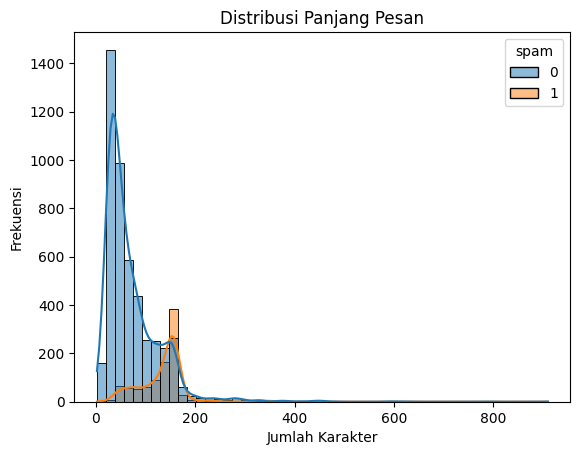

In [ ]:
df['text_len'] = df['text'].apply(len)

sns.histplot(data=df, x='text_len', hue='spam', bins=50, kde=True)
plt.title('Distribusi Panjang Pesan')
plt.xlabel('Jumlah Karakter')
plt.ylabel('Frekuensi')
plt.show()

## 9. Histogram Panjang Teks

Menggunakan Plotly untuk membuat histogram interaktif dari panjang email, tanpa membedakan label.


In [ ]:
fig = px.histogram(df, x='length', marginal='rug',
                   title='Histogram of Text Length')
fig.update_layout(
    xaxis_title='length',
    yaxis_title='Frequency',
    showlegend=True)

## 10. Histogram Panjang Teks Berdasarkan Label

Histogram panjang email yang dibedakan berdasarkan kategori (spam/ham), menggunakan warna yang berbeda.


In [ ]:
fig = px.histogram(df, x='length', color='label', marginal='rug',
                   title='Histogram of Text Length by Category')
fig.update_layout(
    xaxis_title='Length',
    yaxis_title='Frequency',
    showlegend=True)

## 11. WordCloud untuk SPAM dan HAM

Menampilkan visualisasi WordCloud untuk:

- Email spam
- Email ham

Tujuannya untuk mengetahui kata-kata yang sering muncul pada masing-masing kategori.


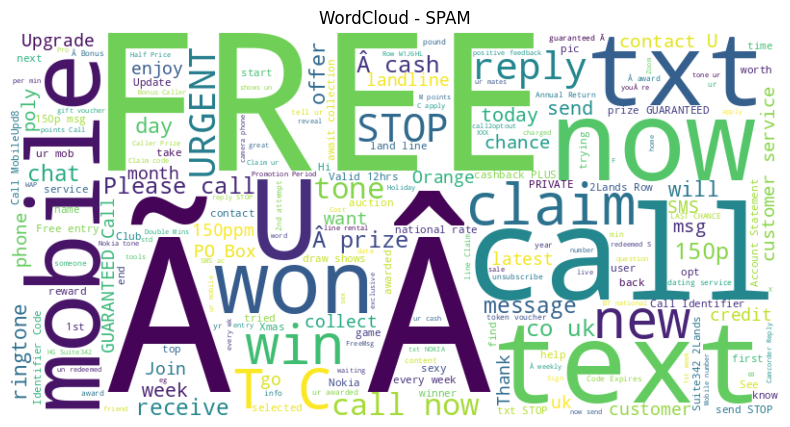

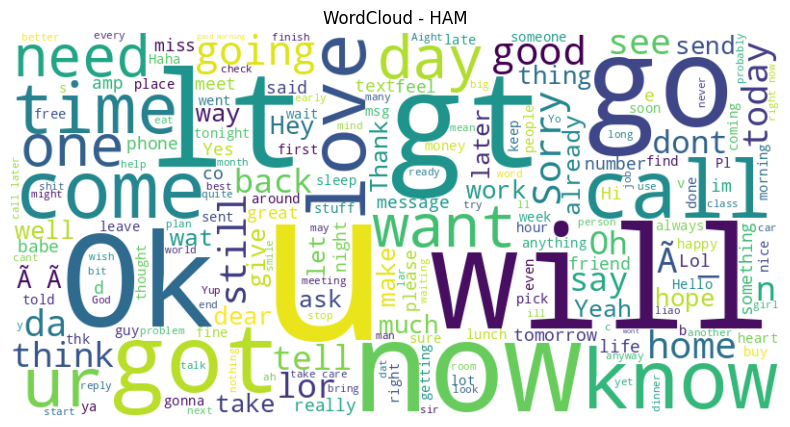

In [ ]:
spam_words = ' '.join(df[df['spam'] == 1]['text'])
ham_words = ' '.join(df[df['spam'] == 0]['text'])


spam_wc = WordCloud(width=800, height=400, background_color='white').generate(spam_words)
plt.figure(figsize=(10, 5))
plt.imshow(spam_wc, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud - SPAM')
plt.show()

ham_wc = WordCloud(width=800, height=400, background_color='white').generate(ham_words)
plt.figure(figsize=(10, 5))
plt.imshow(ham_wc, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud - HAM')
plt.show()

## 12. Bigram Terpopuler pada Email SPAM

Menggunakan `CountVectorizer` untuk mengekstrak pasangan kata (bigram) yang paling sering muncul di email spam.


In [ ]:
vectorizer = CountVectorizer(ngram_range=(2, 2), stop_words='english')
X = vectorizer.fit_transform(df[df['spam'] == 1]['text'])

sum_words = X.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
print("Top 10 Bigram di SPAM:")
for bigram, freq in words_freq[:10]:
    print(f"{bigram} : {freq}")

Top 10 Bigram di SPAM:
chance win : 26
1000 cash : 23
po box : 23
prize guaranteed : 22
send stop : 20
selected receive : 19
national rate : 19
await collection : 19
urgent mobile : 18
land line : 18


## 13. Filter Data SPAM

Menyimpan semua baris dengan label spam ke variabel `df_spam`.


In [ ]:
df_spam=df[df['spam']==1]
df_spam.shape

(947, 5)

## 14. Filter Data HAM

Menyimpan semua baris dengan label ham ke variabel `df_ham`.


In [ ]:
df_ham=df[df['spam']==0]
df_ham.shape

(4816, 5)

## 15. Downsampling Data HAM

Karena data ham lebih banyak dari spam, maka dilakukan downsampling untuk menyeimbangkan jumlah data dari kedua kelas.


In [ ]:
df_ham_downsampled = resample(
    df_ham,
    replace=False,
    n_samples=len(df_spam),
    random_state=42
)

## 16. Gabungkan dan Acak Dataset Seimbang

Menyatukan data spam dan ham hasil downsampling, lalu di-shuffle untuk memastikan distribusi data acak dan tidak berurutan.


In [ ]:
df_balanced = pd.concat([df_ham_downsampled, df_spam])
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)
print(df_balanced['spam'].value_counts())

spam
1    947
0    947
Name: count, dtype: int64


## 17. Split Data: Train & Test

Membagi data menjadi data latih (80%) dan data uji (20%) dengan `stratify=y`, agar proporsi spam/ham tetap seimbang di kedua bagian.


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['spam'], test_size=0.2, random_state=42, stratify=df['spam'])
print("Train spam ratio:")
print(y_train.value_counts(normalize=True))

print("\nTest spam ratio:")
print(y_test.value_counts(normalize=True))

Train spam ratio:
spam
0    0.835575
1    0.164425
Name: proportion, dtype: float64

Test spam ratio:
spam
0    0.83608
1    0.16392
Name: proportion, dtype: float64


## 18. TF-IDF Vectorization

Mengubah teks ke representasi numerik menggunakan TF-IDF (Term Frequency–Inverse Document Frequency), dengan filtering:

- Stopwords bahasa Inggris dihapus
- max_df=0.9 untuk menghindari kata yang terlalu umum


In [ ]:
tfidf = TfidfVectorizer(stop_words='english', max_df=0.9)

X_train_vec = tfidf.fit_transform(X_train)
X_test_vec = tfidf.transform(X_test)

## 19. Latih Model: Logistic Regression & Random Forest

Melatih dua model untuk perbandingan performa:

- Logistic Regression (baseline)
- Random Forest (ensemble method yang biasanya lebih kuat)


In [ ]:
logreg = LogisticRegression(random_state=42)
logreg.fit(X_train_vec, y_train)

LogisticRegression(random_state=42)

In [ ]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_vec, y_train)

RandomForestClassifier(random_state=42)

## 20. Evaluasi Model

Menampilkan hasil evaluasi dari kedua model menggunakan:

- Accuracy
- Confusion Matrix
- Classification Report (precision, recall, F1-score)

Tujuannya untuk mengetahui model mana yang lebih efektif dalam mendeteksi spam.


In [ ]:
print("=== Logistic Regression ===")
y_pred_lr = logreg.predict(X_test_vec)
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print(confusion_matrix(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))

=== Logistic Regression ===
Accuracy: 0.9470945359930616
[[963   1]
 [ 60 129]]
              precision    recall  f1-score   support

           0       0.94      1.00      0.97       964
           1       0.99      0.68      0.81       189

    accuracy                           0.95      1153
   macro avg       0.97      0.84      0.89      1153
weighted avg       0.95      0.95      0.94      1153



In [ ]:
print("\n=== Random Forest ===")
y_pred_rf = rf.predict(X_test_vec)
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print(confusion_matrix(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))


=== Random Forest ===
Accuracy: 0.9592367736339983
[[962   2]
 [ 45 144]]
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       964
           1       0.99      0.76      0.86       189

    accuracy                           0.96      1153
   macro avg       0.97      0.88      0.92      1153
weighted avg       0.96      0.96      0.96      1153



## 21. Inference: Prediksi Email Baru

Pada tahap ini, dibuat sebuah fungsi `predict_email()` untuk menguji model terhadap input email baru. Fungsi ini:

1. Melakukan transformasi teks menggunakan `TF-IDF`.
2. Melakukan prediksi dengan dua model: **Logistic Regression** dan **Random Forest**.
3. Menampilkan hasil prediksi dalam bentuk label: `HAM` atau `SPAM`.

Contoh input yang digunakan adalah email dengan kalimat promosi/pemenang hadiah.


In [ ]:
# === INFERENCE FUNCTION ===

def predict_email(text):
    # Vectorize input
    vec = tfidf.transform([text])

    # Predict with both models
    pred_lr = logreg.predict(vec)[0]
    pred_rf = rf.predict(vec)[0]

    # Konversi label
    label_map = {0: "HAM", 1: "SPAM"}

    print("=== HASIL PREDIKSI ===")
    print(f"Logistic Regression: {label_map[pred_lr]}")
    print(f"Random Forest      : {label_map[pred_rf]}")


email_text = "Congratulations! You've won a free iPhone. Click here to claim now!"
predict_email(email_text)


=== HASIL PREDIKSI ===
Logistic Regression: SPAM
Random Forest      : SPAM
